Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1FllL2kWZ5q1E0alqyLz7TGC1qlKYwJxN'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1pJS8Cc_AeixyHXgXm9uB_KaboX5E-G40'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1IYIIMhI1uQNjxlp9D4WzEBKLk20gE6RC'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1817
Number of dev sentences:  321
Number of test sentences:  378
Number of words in the training dataset:  11597
Number of words in the dev dataset:  4202
Number of words in the test dataset:  5076
Tags in the training dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the training dataset:  3
Tags in the dev dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the dev dataset:  3
Tags in the test dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the test dataset:  3
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 671,“,O
1,Sentence: 671,Agravo,O
2,Sentence: 671,regimental,O
3,Sentence: 671,em,O
4,Sentence: 671,habeas,O
5,Sentence: 671,corpus,O
6,Sentence: 671,.,O
7,Sentence: 671,Homicídio,O
8,Sentence: 671,qualificado,O
9,Sentence: 671,(,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('em', 'O'),
 ('seus', 'O'),
 ('votos', 'O'),
 ('os', 'O'),
 ('argumentos', 'O'),
 ('de', 'O'),
 ('ambas', 'O'),
 ('as', 'O'),
 ('partes', 'O'),
 (',', 'O'),
 ('não', 'O'),
 ('havendo', 'O'),
 ('reconhecer', 'O'),
 (',', 'O'),
 ('agora', 'O'),
 (',', 'O'),
 ('quaisquer', 'O'),
 ('dos', 'O'),
 ('vícios', 'O'),
 ('do', 'O'),
 ('art.', 'B-LEGISLACAO'),
 ('1.022', 'I-LEGISLACAO'),
 (',', 'O'),
 ('do', 'O'),
 ('Código', 'B-LEGISLACAO'),
 ('de', 'I-LEGISLACAO'),
 ('Processo', 'I-LEGISLACAO'),
 ('Civil', 'I-LEGISLACAO'),
 ('.', 'O')]

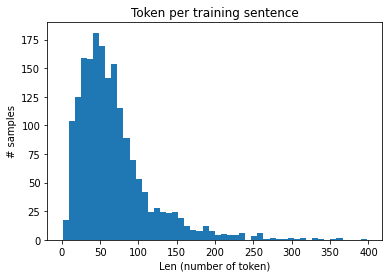

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

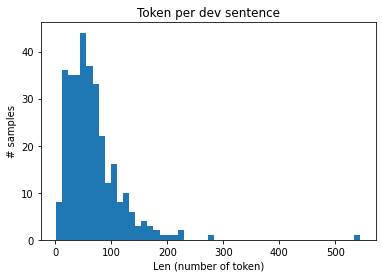

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

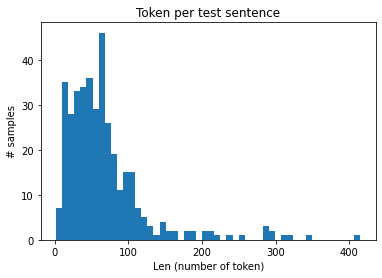

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'civil'
print(word2idx['civil'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-LEGISLACAO'
print(tag2idx['B-LEGISLACAO'])
# Tag of index 0
print(idx2tag[0])

4197
Consta
1
I-LEGISLACAO


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
# X_train, y_train = random_remove_data_points(X_train, y_train, 0.95)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1817
Points in y_train before removal: 1817
Points in X_train before removal: 1817
Points in y_train before removal: 1817


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[1064, 12743, 11813, 8981, 11009, 1987, 157, 9382, 7251, 12743, 2724, 8981, 2891, 13404, 2177, 8734, 3701, 2654, 2294, 2786, 2423, 13441, 2129, 8981, 11899, 3329, 13441, 9883, 5326, 12463, 8981, 12743, 12413, 8981, 4987, 12323, 13402, 8637, 2654, 8981, 11295, 1016, 13441, 8946, 8637, 10774, 9197, 8637, 6167, 8981, 239, 9577, 3946, 2294, 2561, 8637, 4021, 8713, 477, 1226, 2294, 3161, 13441, 4714, 3628]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[4844, 12382, 8981, 10979, 2654, 7340, 5349, 11009, 570, 8637, 5452, 7956, 3989, 732, 10638, 8637, 9954, 8637, 12501, 3110, 8981, 7769, 7308, 8478, 11802, 2324, 12323, 6987, 3962, 8637, 11091, 12710, 7762, 13000, 3218, 6149, 10416, 9397, 8637, 176, 8290, 12323, 10484, 8981, 12323, 5375, 8981, 5820, 3701, 12323, 13343, 373, 11899, 7543, 8713, 3663, 10338, 11719, 12496, 2603, 8981, 10515, 8981, 871

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 31.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 28.5 MB/s 
     |████████████████████████████████| 163 kB 58.1 MB/s 
     |████████████████████████████████| 7.6 MB 64.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=dcb382f90f6c65967ff60f59809066e1a17d0315e1633d6cb13941ac1d667c9b
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[1064, 12743, 11813, 8981, 11009, 1987, 157, 9382, 7251, 1

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

from transformers import pipeline
from future.utils import iteritems

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [4]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [5]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [6]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [7]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word = generate_sentences(X_train, y_train, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[updated_idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[updated_idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[updated_idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0860687494277954
Training loss per 100 training steps: 0.08232921017518285
Training loss epoch: 0.06542055560341499
Training accuracy epoch: 0.9787939822176966
Validating model...
Validation Loss: 0.031400268453927266
Validation Accuracy: 0.9904711606297779
Training epoch: 2
Training loss per 100 training steps: 0.007571236230432987
Training loss per 100 training steps: 0.015688498618569927
Training loss epoch: 0.015368090184982603
Training accuracy epoch: 0.9954272336567129
Validating model...
Validation Loss: 0.01093589163515606
Validation Accuracy: 0.9966836190730497
Training epoch: 3
Training loss per 100 training steps: 0.006698808632791042
Training loss per 100 training steps: 0.010282717790975613
Training loss epoch: 0.010230487440860319
Training accuracy epoch: 0.9971559026059924
Validating model...
Validation Loss: 0.013041534976288122
Validation Accuracy: 0.9959156448082012
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013377219242405166
Validation Accuracy: 0.9967429818000327
Validation duration: 0.21987561666666502 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0292695760726929
Training loss per 100 training steps: 0.0767454173793961
Training loss epoch: 0.060458672865831724
Training accuracy epoch: 0.9800361461457571
Validating model...
Validation Loss: 0.01625418139987492
Validation Accuracy: 0.9949182989373891
Training epoch: 2
Training loss per 100 training steps: 0.01807083562016487
Training loss per 100 training steps: 0.01694233206418887
Training loss epoch: 0.016149072083939706
Training accuracy epoch: 0.9949807814813835
Validating model...
Validation Loss: 0.015037555502550233
Validation Accuracy: 0.995335455314505
Training epoch: 3
Training loss per 100 training steps: 0.0016845890786498785
Training loss per 100 training steps: 0.00867896949086283
Training loss epoch: 0.008253968711229185
Training accuracy epoch: 0.9975357443206238
Validating model...
Validation Loss: 0.014028300992712113
Validation Accuracy: 0.9961734515656702
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012956496638556322
Validation Accuracy: 0.9967908849037261
Validation duration: 0.22054298333332553 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1854203939437866
Training loss per 100 training steps: 0.08716074922260376
Training loss epoch: 0.06789082506651872
Training accuracy epoch: 0.9768091230463225
Validating model...
Validation Loss: 0.014698125760159678
Validation Accuracy: 0.9947055089421971
Training epoch: 2
Training loss per 100 training steps: 0.012730628252029419
Training loss per 100 training steps: 0.012217954319837217
Training loss epoch: 0.011728259527393368
Training accuracy epoch: 0.9967251061284869
Validating model...
Validation Loss: 0.015557506631705024
Validation Accuracy: 0.9958727092082447
Training epoch: 3
Training loss per 100 training steps: 0.003720623906701803
Training loss per 100 training steps: 0.008486600790119795
Training loss epoch: 0.00852344215549955
Training accuracy epoch: 0.9974435344320429
Validating model...
Validation Loss: 0.012507042497634843
Validation Accuracy: 0.9969482792036082
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013353489403016283
Validation Accuracy: 0.996524580158583
Validation duration: 0.2233278500000021 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1224209070205688
Training loss per 100 training steps: 0.07824731024793617
Training loss epoch: 0.06245928624985923
Training accuracy epoch: 0.9791847114907235
Validating model...
Validation Loss: 0.014684658980556941
Validation Accuracy: 0.9959640756636458
Training epoch: 2
Training loss per 100 training steps: 0.025143468752503395
Training loss per 100 training steps: 0.010714503959522094
Training loss epoch: 0.010449016591350377
Training accuracy epoch: 0.9967068937262055
Validating model...
Validation Loss: 0.016600020924150676
Validation Accuracy: 0.9954486075405197
Training epoch: 3
Training loss per 100 training steps: 0.006568460259586573
Training loss per 100 training steps: 0.007759572541004619
Training loss epoch: 0.0072990159709482045
Training accuracy epoch: 0.9978110122861898
Validating model...
Validation Loss: 0.0118329319607472
Validation Accuracy: 0.9970217507578929
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.009997340152646453
Validation Accuracy: 0.9970518112460541
Validation duration: 0.22304526666666788 minutes
F1-score (test): 98.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.284462332725525
Training loss per 100 training steps: 0.08952537832302179
Training loss epoch: 0.06970020597735026
Training accuracy epoch: 0.9762429447526555
Validating model...
Validation Loss: 0.013842408678361348
Validation Accuracy: 0.9960599450157813
Training epoch: 2
Training loss per 100 training steps: 0.0349896065890789
Training loss per 100 training steps: 0.01342074235896626
Training loss epoch: 0.012596467691047353
Training accuracy epoch: 0.996201907038875
Validating model...
Validation Loss: 0.013903039368978213
Validation Accuracy: 0.9962532670638411
Training epoch: 3
Training loss per 100 training steps: 0.00346291228197515
Training loss per 100 training steps: 0.008011103527606603
Training loss epoch: 0.008254624854832311
Training accuracy epoch: 0.9975849680659398
Validating model...
Validation Loss: 0.015099356860099803
Validation Accuracy: 0.9943997863576867
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014185484011856412
Validation Accuracy: 0.9972978567837866
Validation duration: 0.2211856333333344 minutes
F1-score (test): 98.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.99      0.98      1238

   micro avg       0.98      0.99      0.98      1238
   macro avg       0.98      0.99      0.98      1238
weighted avg       0.98      0.99      0.98      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9890460968017578
Training loss per 100 training steps: 0.07825138962753855
Training loss epoch: 0.06085584139694053
Training accuracy epoch: 0.981294675306506
Validating model...
Validation Loss: 0.012345167409096445
Validation Accuracy: 0.9964435811088217
Training epoch: 2
Training loss per 100 training steps: 0.008445598185062408
Training loss per 100 training steps: 0.01260841535381272
Training loss epoch: 0.013014516772695777
Training accuracy epoch: 0.9960785053154569
Validating model...
Validation Loss: 0.01219751080636689
Validation Accuracy: 0.9962887052951862
Training epoch: 3
Training loss per 100 training steps: 0.005709276534616947
Training loss per 100 training steps: 0.009884695906888251
Training loss epoch: 0.009273864651872764
Training accuracy epoch: 0.9971942928070748
Validating model...
Validation Loss: 0.010224602204592278
Validation Accuracy: 0.997481699540336
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01253793668365688
Validation Accuracy: 0.9964940711021688
Validation duration: 0.22304996666665222 minutes
F1-score (test): 98.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9331566095352173
Training loss per 100 training steps: 0.08360751988458456
Training loss epoch: 0.0654440809969305
Training accuracy epoch: 0.9806266730510577
Validating model...
Validation Loss: 0.011588027404199931
Validation Accuracy: 0.9963116490840804
Training epoch: 2
Training loss per 100 training steps: 0.01412385143339634
Training loss per 100 training steps: 0.012692732620629307
Training loss epoch: 0.012004535130395646
Training accuracy epoch: 0.9963565219986762
Validating model...
Validation Loss: 0.008549935991011028
Validation Accuracy: 0.9973687780974311
Training epoch: 3
Training loss per 100 training steps: 0.007882938720285892
Training loss per 100 training steps: 0.007411989721695496
Training loss epoch: 0.007688773039672655
Training accuracy epoch: 0.9976461179908647
Validating model...
Validation Loss: 0.01677532191249719
Validation Accuracy: 0.9954342442932935
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014044602959378002
Validation Accuracy: 0.9961456897976384
Validation duration: 0.22011575000002873 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2049622535705566
Training loss per 100 training steps: 0.08202141848402006
Training loss epoch: 0.06491058241103737
Training accuracy epoch: 0.9772304812953275
Validating model...
Validation Loss: 0.016128178126001286
Validation Accuracy: 0.9950729867126468
Training epoch: 2
Training loss per 100 training steps: 0.013143068179488182
Training loss per 100 training steps: 0.013806598007420796
Training loss epoch: 0.012302225664287517
Training accuracy epoch: 0.9963143613944581
Validating model...
Validation Loss: 0.011992827310764585
Validation Accuracy: 0.9966892620279209
Training epoch: 3
Training loss per 100 training steps: 0.00246641063131392
Training loss per 100 training steps: 0.008011931696985065
Training loss epoch: 0.007493151925072979
Training accuracy epoch: 0.9977740424113714
Validating model...
Validation Loss: 0.016346728180776284
Validation Accuracy: 0.9954233657315376
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012853215806444496
Validation Accuracy: 0.9968050980952543
Validation duration: 0.22015700000004776 minutes
F1-score (test): 98.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.171086072921753
Training loss per 100 training steps: 0.08689488680793507
Training loss epoch: 0.06841112626388564
Training accuracy epoch: 0.9766413102620655
Validating model...
Validation Loss: 0.01400891526247419
Validation Accuracy: 0.9960843179490744
Training epoch: 2
Training loss per 100 training steps: 0.020419368520379066
Training loss per 100 training steps: 0.0139860958944416
Training loss epoch: 0.013828656960829673
Training accuracy epoch: 0.9958478471905862
Validating model...
Validation Loss: 0.012068734726025945
Validation Accuracy: 0.9966171457243773
Training epoch: 3
Training loss per 100 training steps: 0.002090692985802889
Training loss per 100 training steps: 0.00693241567904185
Training loss epoch: 0.006918204512978366
Training accuracy epoch: 0.997875182589181
Validating model...
Validation Loss: 0.011269969011274432
Validation Accuracy: 0.9971101051091602
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011831121712020831
Validation Accuracy: 0.9969945010070838
Validation duration: 0.22333131666667516 minutes
F1-score (test): 97.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0889582633972168
Training loss per 100 training steps: 0.10415541166716283
Training loss epoch: 0.07982803122665157
Training accuracy epoch: 0.9744858849344112
Validating model...
Validation Loss: 0.01464344579948201
Validation Accuracy: 0.9959755601258452
Training epoch: 2
Training loss per 100 training steps: 0.005639960523694754
Training loss per 100 training steps: 0.012117196410424122
Training loss epoch: 0.01279517186602289
Training accuracy epoch: 0.996308509560914
Validating model...
Validation Loss: 0.014734974970841514
Validation Accuracy: 0.9948379436217994
Training epoch: 3
Training loss per 100 training steps: 0.0016223194543272257
Training loss per 100 training steps: 0.008116560006090024
Training loss epoch: 0.008205916038156867
Training accuracy epoch: 0.9976292747475207
Validating model...
Validation Loss: 0.016320905287838763
Validation Accuracy: 0.996606952174445
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011977012592372679
Validation Accuracy: 0.996976349706164
Validation duration: 0.2199723499999891 minutes
F1-score (test): 98.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9259651899337769
Training loss per 100 training steps: 0.08664982521095045
Training loss epoch: 0.05886697201112732
Training accuracy epoch: 0.9819004789929399
Validating model...
Validation Loss: 0.01588757356096591
Validation Accuracy: 0.9957030530004225
Training epoch: 2
Training loss per 100 training steps: 0.014247862622141838
Training loss per 100 training steps: 0.014943510854137268
Training loss epoch: 0.013314986013948961
Training accuracy epoch: 0.9961171686238919
Validating model...
Validation Loss: 0.008172163960850975
Validation Accuracy: 0.9978055725505416
Training epoch: 3
Training loss per 100 training steps: 0.002612123964354396
Training loss per 100 training steps: 0.006589516255910056
Training loss epoch: 0.006434367524054206
Training accuracy epoch: 0.9981559291738964
Validating model...
Validation Loss: 0.00879051014462242
Validation Accuracy: 0.9977325443356087
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01177542043660651
Validation Accuracy: 0.9962724426826646
Validation duration: 0.2232415166666518 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8659623861312866
Training loss per 100 training steps: 0.07690821040772122
Training loss epoch: 0.05362773854666722
Training accuracy epoch: 0.9841178162053001
Validating model...
Validation Loss: 0.01640018455440267
Validation Accuracy: 0.9950669365165565
Training epoch: 2
Training loss per 100 training steps: 0.01863662153482437
Training loss per 100 training steps: 0.01228437213328584
Training loss epoch: 0.011685512357456773
Training accuracy epoch: 0.9964131604521612
Validating model...
Validation Loss: 0.013220945119558434
Validation Accuracy: 0.9962727913138969
Training epoch: 3
Training loss per 100 training steps: 0.005918063689023256
Training loss per 100 training steps: 0.006734181146510867
Training loss epoch: 0.007699169772193762
Training accuracy epoch: 0.9976780664736552
Validating model...
Validation Loss: 0.014390244263701052
Validation Accuracy: 0.9962629227086394
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016924318915547094
Validation Accuracy: 0.9967263191203659
Validation duration: 0.22041484999996708 minutes
F1-score (test): 98.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2903555631637573
Training loss per 100 training steps: 0.08223190314440738
Training loss epoch: 0.05714373719165025
Training accuracy epoch: 0.9803801368653815
Validating model...
Validation Loss: 0.01261617453946244
Validation Accuracy: 0.9964226324787255
Training epoch: 2
Training loss per 100 training steps: 0.022369462996721268
Training loss per 100 training steps: 0.012163695968032842
Training loss epoch: 0.011327214752819541
Training accuracy epoch: 0.9966227314994757
Validating model...
Validation Loss: 0.00947615635093479
Validation Accuracy: 0.9971813742177386
Training epoch: 3
Training loss per 100 training steps: 0.003606528276577592
Training loss per 100 training steps: 0.010013649255120298
Training loss epoch: 0.008843348869422113
Training accuracy epoch: 0.9972306501946243
Validating model...
Validation Loss: 0.009721270084680458
Validation Accuracy: 0.997467779847713
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011271824145903034
Validation Accuracy: 0.9964295350500642
Validation duration: 0.22032983333325926 minutes
F1-score (test): 97.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0387800931930542
Training loss per 100 training steps: 0.08302518227921411
Training loss epoch: 0.05675162424943383
Training accuracy epoch: 0.9822029025002834
Validating model...
Validation Loss: 0.015265940057967478
Validation Accuracy: 0.9958911575573486
Training epoch: 2
Training loss per 100 training steps: 0.005879840347915888
Training loss per 100 training steps: 0.01270862013830038
Training loss epoch: 0.011763598416912865
Training accuracy epoch: 0.9964750358157376
Validating model...
Validation Loss: 0.013553476479414496
Validation Accuracy: 0.9963290997304297
Training epoch: 3
Training loss per 100 training steps: 0.0008966586901806295
Training loss per 100 training steps: 0.007813398063524008
Training loss epoch: 0.007215539027857785
Training accuracy epoch: 0.997752415684191
Validating model...
Validation Loss: 0.007703873768886773
Validation Accuracy: 0.9981510813773118
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.007750113752990728
Validation Accuracy: 0.9973812938507386
Validation duration: 0.22044228333337135 minutes
F1-score (test): 98.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.058682918548584
Training loss per 100 training steps: 0.07965739764789544
Training loss epoch: 0.055914956701875865
Training accuracy epoch: 0.9817262943809801
Validating model...
Validation Loss: 0.013342838310303964
Validation Accuracy: 0.9961445551808539
Training epoch: 2
Training loss per 100 training steps: 0.008082612417638302
Training loss per 100 training steps: 0.011243588153946
Training loss epoch: 0.011040400578204695
Training accuracy epoch: 0.9966433260051422
Validating model...
Validation Loss: 0.010820801694145692
Validation Accuracy: 0.9967264217548529
Training epoch: 3
Training loss per 100 training steps: 0.011241622269153595
Training loss per 100 training steps: 0.006196425026939665
Training loss epoch: 0.006089916997058154
Training accuracy epoch: 0.9980715285118321
Validating model...
Validation Loss: 0.011159198574854859
Validation Accuracy: 0.9962934834490353
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012486208623158745
Validation Accuracy: 0.9961022018544949
Validation duration: 0.22057558333338723 minutes
F1-score (test): 97.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1206191778182983
Training loss per 100 training steps: 0.08411673450897826
Training loss epoch: 0.05787661092829678
Training accuracy epoch: 0.9808200516137163
Validating model...
Validation Loss: 0.01417273620609194
Validation Accuracy: 0.9958272035460863
Training epoch: 2
Training loss per 100 training steps: 0.012458531185984612
Training loss per 100 training steps: 0.012960998205431175
Training loss epoch: 0.012130679787349021
Training accuracy epoch: 0.9964638089268208
Validating model...
Validation Loss: 0.012417818602573658
Validation Accuracy: 0.9963192533901041
Training epoch: 3
Training loss per 100 training steps: 0.004489076789468527
Training loss per 100 training steps: 0.010049421072817675
Training loss epoch: 0.00878344458096922
Training accuracy epoch: 0.9974770410847822
Validating model...
Validation Loss: 0.009449460625460017
Validation Accuracy: 0.9975572925811298
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014284608068313295
Validation Accuracy: 0.9959875218231247
Validation duration: 0.22000518333334185 minutes
F1-score (test): 97.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0166269540786743
Training loss per 100 training steps: 0.08597683858605895
Training loss epoch: 0.05875331990023236
Training accuracy epoch: 0.9819305958309203
Validating model...
Validation Loss: 0.012336959995861565
Validation Accuracy: 0.9963193284351219
Training epoch: 2
Training loss per 100 training steps: 0.02067367546260357
Training loss per 100 training steps: 0.012341887163376381
Training loss epoch: 0.012690773594590742
Training accuracy epoch: 0.9962470065685806
Validating model...
Validation Loss: 0.014226434430817054
Validation Accuracy: 0.995648629219861
Training epoch: 3
Training loss per 100 training steps: 0.006468061823397875
Training loss per 100 training steps: 0.009154395433719095
Training loss epoch: 0.008555110885383159
Training accuracy epoch: 0.9975577017909897
Validating model...
Validation Loss: 0.009654381611090642
Validation Accuracy: 0.9970888980807041
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014189792488953875
Validation Accuracy: 0.9963225310492727
Validation duration: 0.22215326666664623 minutes
F1-score (test): 97.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.185909390449524
Training loss per 100 training steps: 0.07744741420916254
Training loss epoch: 0.05399826528607971
Training accuracy epoch: 0.9818713957795524
Validating model...
Validation Loss: 0.017496485817467884
Validation Accuracy: 0.9953187239215252
Training epoch: 2
Training loss per 100 training steps: 0.029128538444638252
Training loss per 100 training steps: 0.01192902924555197
Training loss epoch: 0.010933922671465127
Training accuracy epoch: 0.9967755030184808
Validating model...
Validation Loss: 0.018883752324091757
Validation Accuracy: 0.9946155502463241
Training epoch: 3
Training loss per 100 training steps: 0.04158756136894226
Training loss per 100 training steps: 0.007083558665339531
Training loss epoch: 0.006895589037173379
Training accuracy epoch: 0.9979984655232532
Validating model...
Validation Loss: 0.03716286777662823
Validation Accuracy: 0.9922912483839325
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013068227814073907
Validation Accuracy: 0.9959671121116038
Validation duration: 0.22006055000007715 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1050846576690674
Training loss per 100 training steps: 0.07825641169922777
Training loss epoch: 0.05490655448609059
Training accuracy epoch: 0.9820652988400618
Validating model...
Validation Loss: 0.015482853133497494
Validation Accuracy: 0.9949060384240963
Training epoch: 2
Training loss per 100 training steps: 0.005680826026946306
Training loss per 100 training steps: 0.011729774641052884
Training loss epoch: 0.01153493307194569
Training accuracy epoch: 0.9965406121925893
Validating model...
Validation Loss: 0.015386709657572542
Validation Accuracy: 0.9952362516899733
Training epoch: 3
Training loss per 100 training steps: 0.005903121083974838
Training loss per 100 training steps: 0.0061258167287191875
Training loss epoch: 0.007367313926125882
Training accuracy epoch: 0.9979422874868435
Validating model...
Validation Loss: 0.012511301598957894
Validation Accuracy: 0.9966436975913991
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013994202030365463
Validation Accuracy: 0.9968760182372671
Validation duration: 0.22040040000004713 minutes
F1-score (test): 98.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.99      0.98      1238

   micro avg       0.98      0.99      0.98      1238
   macro avg       0.98      0.99      0.98      1238
weighted avg       0.98      0.99      0.98      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1742044687271118
Training loss per 100 training steps: 0.08001080809142624
Training loss epoch: 0.05433486789200803
Training accuracy epoch: 0.9817210651448307
Validating model...
Validation Loss: 0.012962547020011005
Validation Accuracy: 0.9963855809912571
Training epoch: 2
Training loss per 100 training steps: 0.004071371629834175
Training loss per 100 training steps: 0.011288750053401853
Training loss epoch: 0.010356402608745714
Training accuracy epoch: 0.9971132739629257
Validating model...
Validation Loss: 0.022029498126357794
Validation Accuracy: 0.9942366903473285
Training epoch: 3
Training loss per 100 training steps: 0.0011002221144735813
Training loss per 100 training steps: 0.006984295543354687
Training loss epoch: 0.0067587100751105725
Training accuracy epoch: 0.9979805571919227
Validating model...
Validation Loss: 0.009711591273246865
Validation Accuracy: 0.9975290084986612
Training epoch: 4
Training loss per 100 tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016735703730470657
Validation Accuracy: 0.9964642681851498
Validation duration: 0.2216525499999989 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1952024698257446
Training loss per 100 training steps: 0.08477844408768608
Training loss epoch: 0.05302254419689577
Training accuracy epoch: 0.9820578021944811
Validating model...
Validation Loss: 0.01292804249429277
Validation Accuracy: 0.996622408545627
Training epoch: 2
Training loss per 100 training steps: 0.005022761877626181
Training loss per 100 training steps: 0.012068973547009068
Training loss epoch: 0.011869908868857009
Training accuracy epoch: 0.9966323043027036
Validating model...
Validation Loss: 0.012546036822078306
Validation Accuracy: 0.9966090490578241
Training epoch: 3
Training loss per 100 training steps: 0.0028199995867908
Training loss per 100 training steps: 0.007118918854019393
Training loss epoch: 0.007031120238217277
Training accuracy epoch: 0.997907795262988
Validating model...
Validation Loss: 0.014229354079967985
Validation Accuracy: 0.9961342391931486
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016252614540765837
Validation Accuracy: 0.9951132561121705
Validation duration: 0.22038086666664944 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 97.4%
              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.027701735496521
Training loss per 100 training steps: 0.07839699642327015
Training loss epoch: 0.05007058520211684
Training accuracy epoch: 0.9839001613676529
Validating model...
Validation Loss: 0.011469153022127492
Validation Accuracy: 0.9966368460346947
Training epoch: 2
Training loss per 100 training steps: 0.01464808452874422
Training loss per 100 training steps: 0.012221182017624009
Training loss epoch: 0.012689933358649513
Training accuracy epoch: 0.9960864646883479
Validating model...
Validation Loss: 0.011280124562160512
Validation Accuracy: 0.9970574902640288
Training epoch: 3
Training loss per 100 training steps: 0.009129664860665798
Training loss per 100 training steps: 0.006301514375009712
Training loss epoch: 0.006532978770748979
Training accuracy epoch: 0.9980582856009166
Validating model...
Validation Loss: 0.019937582567460293
Validation Accuracy: 0.9944652245249146
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011620478541772172
Validation Accuracy: 0.996143178729148
Validation duration: 0.21945909999994911 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0264118909835815
Training loss per 100 training steps: 0.09603931219086494
Training loss epoch: 0.05823180201491481
Training accuracy epoch: 0.9817527914318298
Validating model...
Validation Loss: 0.017946756643054652
Validation Accuracy: 0.9953405002273515
Training epoch: 2
Training loss per 100 training steps: 0.00508110411465168
Training loss per 100 training steps: 0.01050687938845615
Training loss epoch: 0.011195726174950113
Training accuracy epoch: 0.9966929577772672
Validating model...
Validation Loss: 0.012105836563499733
Validation Accuracy: 0.9967511252845288
Training epoch: 3
Training loss per 100 training steps: 0.0011694419663399458
Training loss per 100 training steps: 0.0053008965969818765
Training loss epoch: 0.006391236543200264
Training accuracy epoch: 0.9980888853494975
Validating model...
Validation Loss: 0.011791433415575219
Validation Accuracy: 0.9965791845523905
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.009481165448960382
Validation Accuracy: 0.9976581871859574
Validation duration: 0.22235208333343812 minutes
F1-score (test): 98.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.99      0.98      1238

   micro avg       0.98      0.99      0.98      1238
   macro avg       0.98      0.99      0.98      1238
weighted avg       0.98      0.99      0.98      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1358158588409424
Training loss per 100 training steps: 0.08585530385089171
Training loss epoch: 0.05323034152622573
Training accuracy epoch: 0.9821078801176091
Validating model...
Validation Loss: 0.013727096912805877
Validation Accuracy: 0.996842845918594
Training epoch: 2
Training loss per 100 training steps: 0.005200405139476061
Training loss per 100 training steps: 0.009143653459441249
Training loss epoch: 0.009189984194311926
Training accuracy epoch: 0.9972215540046908
Validating model...
Validation Loss: 0.012994078096068864
Validation Accuracy: 0.996671768499944
Training epoch: 3
Training loss per 100 training steps: 0.005704366136342287
Training loss per 100 training steps: 0.005913848618430427
Training loss epoch: 0.007118169598114073
Training accuracy epoch: 0.997745275221308
Validating model...
Validation Loss: 0.010378814443746316
Validation Accuracy: 0.9969057796795072
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013092688715308517
Validation Accuracy: 0.9967043198584163
Validation duration: 0.22295108333346433 minutes
F1-score (test): 97.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.98      0.98      1238

   micro avg       0.98      0.98      0.98      1238
   macro avg       0.98      0.98      0.98      1238
weighted avg       0.98      0.98      0.98      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.197015404701233
Training loss per 100 training steps: 0.0872569739781689
Training loss epoch: 0.054533424779033314
Training accuracy epoch: 0.9813805554521134
Validating model...
Validation Loss: 0.015013500515903746
Validation Accuracy: 0.9956480068493725
Training epoch: 2
Training loss per 100 training steps: 0.008149374276399612
Training loss per 100 training steps: 0.009589110284993001
Training loss epoch: 0.009918822693093281
Training accuracy epoch: 0.9970607195541769
Validating model...
Validation Loss: 0.009498801821748549
Validation Accuracy: 0.9971411091025874
Training epoch: 3
Training loss per 100 training steps: 0.0014259879244491458
Training loss per 100 training steps: 0.005006054004234732
Training loss epoch: 0.006252597126350434
Training accuracy epoch: 0.9980365207010244
Validating model...
Validation Loss: 0.009551517722900912
Validation Accuracy: 0.997186343428178
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016592256207028793
Validation Accuracy: 0.9956119579398678
Validation duration: 0.22077516666662025 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 97.3%
              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1715095043182373
Training loss per 100 training steps: 0.08412582677844359
Training loss epoch: 0.05194157331447168
Training accuracy epoch: 0.9822795938260726
Validating model...
Validation Loss: 0.010653694287785107
Validation Accuracy: 0.9967703760361833
Training epoch: 2
Training loss per 100 training steps: 0.009936646558344364
Training loss per 100 training steps: 0.012373988973069013
Training loss epoch: 0.010768232802332767
Training accuracy epoch: 0.9968922469905033
Validating model...
Validation Loss: 0.015685607183037235
Validation Accuracy: 0.9962542625794
Training epoch: 3
Training loss per 100 training steps: 0.0011943710269406438
Training loss per 100 training steps: 0.0066091920952842855
Training loss epoch: 0.007188182341136113
Training accuracy epoch: 0.9977640460345188
Validating model...
Validation Loss: 0.019859151263344324
Validation Accuracy: 0.9960927788502856
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013934644097995866
Validation Accuracy: 0.9972117841348004
Validation duration: 0.22317138333334394 minutes
F1-score (test): 98.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.341079592704773
Training loss per 100 training steps: 0.11563754715209845
Training loss epoch: 0.06865731017060353
Training accuracy epoch: 0.9771776994962291
Validating model...
Validation Loss: 0.014922397643593805
Validation Accuracy: 0.994703370729891
Training epoch: 2
Training loss per 100 training steps: 0.009768908843398094
Training loss per 100 training steps: 0.010161852407601136
Training loss epoch: 0.010076765682964806
Training accuracy epoch: 0.9968890281448606
Validating model...
Validation Loss: 0.009637198839863274
Validation Accuracy: 0.9973698004777337
Training epoch: 3
Training loss per 100 training steps: 0.04408099502325058
Training loss per 100 training steps: 0.006589561182426953
Training loss epoch: 0.006254518293013946
Training accuracy epoch: 0.9981419241326157
Validating model...
Validation Loss: 0.01056462035852573
Validation Accuracy: 0.9973615670718304
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01492350731859915
Validation Accuracy: 0.9957820454266683
Validation duration: 0.21938035000008918 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3705042600631714
Training loss per 100 training steps: 0.0932201492590922
Training loss epoch: 0.05690624481347862
Training accuracy epoch: 0.9803696245348629
Validating model...
Validation Loss: 0.015304486572165928
Validation Accuracy: 0.994969489022641
Training epoch: 2
Training loss per 100 training steps: 0.007872332818806171
Training loss per 100 training steps: 0.010414012720448767
Training loss epoch: 0.011308878262108427
Training accuracy epoch: 0.9966378526910062
Validating model...
Validation Loss: 0.012393093616646226
Validation Accuracy: 0.9969054447349002
Training epoch: 3
Training loss per 100 training steps: 0.0017618214478716254
Training loss per 100 training steps: 0.0070764029045280365
Training loss epoch: 0.007620447120616381
Training accuracy epoch: 0.997735249713229
Validating model...
Validation Loss: 0.010640985468247285
Validation Accuracy: 0.9967795870019367
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012927322245862646
Validation Accuracy: 0.9966600916319609
Validation duration: 0.2226927999998831 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9462398290634155
Training loss per 100 training steps: 0.0765451355214867
Training loss epoch: 0.04884349042315729
Training accuracy epoch: 0.9845240775426326
Validating model...
Validation Loss: 0.012560364579604496
Validation Accuracy: 0.9962561006575854
Training epoch: 2
Training loss per 100 training steps: 0.01686190441250801
Training loss per 100 training steps: 0.009916258631228
Training loss epoch: 0.009978044423158866
Training accuracy epoch: 0.996960432277784
Validating model...
Validation Loss: 0.009318404993835083
Validation Accuracy: 0.9974120837466897
Training epoch: 3
Training loss per 100 training steps: 0.00903745461255312
Training loss per 100 training steps: 0.007337737091676341
Training loss epoch: 0.006485877444806167
Training accuracy epoch: 0.9980295610752548
Validating model...
Validation Loss: 0.011938740302173841
Validation Accuracy: 0.9970103622191837
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01298901270274655
Validation Accuracy: 0.9962021101905486
Validation duration: 0.21929458333324875 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9505318999290466
Training loss per 100 training steps: 0.07660540251411718
Training loss epoch: 0.04738798521894344
Training accuracy epoch: 0.9852189895559815
Validating model...
Validation Loss: 0.014561034752876453
Validation Accuracy: 0.9959365405199281
Training epoch: 2
Training loss per 100 training steps: 0.022043967619538307
Training loss per 100 training steps: 0.010043368250359827
Training loss epoch: 0.010791245891961817
Training accuracy epoch: 0.996906246618425
Validating model...
Validation Loss: 0.010263576765456014
Validation Accuracy: 0.9973083872802178
Training epoch: 3
Training loss per 100 training steps: 0.012514202855527401
Training loss per 100 training steps: 0.006688857412468273
Training loss epoch: 0.007434955934979883
Training accuracy epoch: 0.9977764334814364
Validating model...
Validation Loss: 0.014738519770270657
Validation Accuracy: 0.9959372625578171
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013933202249366635
Validation Accuracy: 0.9962926921773935
Validation duration: 0.22243974999995164 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1419353485107422
Training loss per 100 training steps: 0.092795484182932
Training loss per 100 training steps: 0.05595768073953651
Training loss epoch: 0.0510574416022568
Training accuracy epoch: 0.9832381080949688
Validating model...
Validation Loss: 0.014745538423691565
Validation Accuracy: 0.9956068504187336
Training epoch: 2
Training loss per 100 training steps: 0.0014129901537671685
Training loss per 100 training steps: 0.00961019775120191
Training loss per 100 training steps: 0.010831162281941382
Training loss epoch: 0.010810610620976883
Training accuracy epoch: 0.9967778401694152
Validating model...
Validation Loss: 0.01585737360818755
Validation Accuracy: 0.994958646513202
Training epoch: 3
Training loss per 100 training steps: 0.00905467476695776
Training loss per 100 training steps: 0.007773159254782621
Training loss per 100 training steps: 0.006730665056473941
Training loss epoch: 0.006832403324918695
Training accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014535445894580334
Validation Accuracy: 0.9962302040589469
Validation duration: 0.21781643333333706 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0245609283447266
Training loss per 100 training steps: 0.08278388601017765
Training loss per 100 training steps: 0.05122430681074919
Training loss epoch: 0.04674268301715257
Training accuracy epoch: 0.9850008775564093
Validating model...
Validation Loss: 0.020027910080638582
Validation Accuracy: 0.9941274706785448
Training epoch: 2
Training loss per 100 training steps: 0.010410470888018608
Training loss per 100 training steps: 0.009939018936048602
Training loss per 100 training steps: 0.009851732504998904
Training loss epoch: 0.009938446675700936
Training accuracy epoch: 0.9971062880748094
Validating model...
Validation Loss: 0.00980914813616047
Validation Accuracy: 0.9973282096191383
Training epoch: 3
Training loss per 100 training steps: 0.0009541322360746562
Training loss per 100 training steps: 0.005842393833860331
Training loss per 100 training steps: 0.006705993216106001
Training loss epoch: 0.006833946407520368
Training a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011842040462700728
Validation Accuracy: 0.9966626043481347
Validation duration: 0.2149365166666636 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1622706651687622
Training loss per 100 training steps: 0.08326862830355174
Training loss per 100 training steps: 0.05216320544777818
Training loss epoch: 0.04769144099682627
Training accuracy epoch: 0.9839549035157343
Validating model...
Validation Loss: 0.013147275087595474
Validation Accuracy: 0.9957266644481461
Training epoch: 2
Training loss per 100 training steps: 0.011539299041032791
Training loss per 100 training steps: 0.010630988874956782
Training loss per 100 training steps: 0.009879598199431575
Training loss epoch: 0.00971522545921943
Training accuracy epoch: 0.9971428022994614
Validating model...
Validation Loss: 0.010779292360807415
Validation Accuracy: 0.9973596552478059
Training epoch: 3
Training loss per 100 training steps: 0.005942824762314558
Training loss per 100 training steps: 0.0057809685041671525
Training loss per 100 training steps: 0.006233055204059233
Training loss epoch: 0.006218931796881901
Training a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015205156246035282
Validation Accuracy: 0.9959697071368274
Validation duration: 0.21506851666669416 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.209105372428894
Training loss per 100 training steps: 0.08166060806482588
Training loss per 100 training steps: 0.050688180852384856
Training loss epoch: 0.04641304403112531
Training accuracy epoch: 0.9841889199010408
Validating model...
Validation Loss: 0.01047228456618974
Validation Accuracy: 0.997022267061896
Training epoch: 2
Training loss per 100 training steps: 0.0360465943813324
Training loss per 100 training steps: 0.01208718289681111
Training loss per 100 training steps: 0.010481187617215119
Training loss epoch: 0.010548750653310492
Training accuracy epoch: 0.9967830605421975
Validating model...
Validation Loss: 0.009600220609822177
Validation Accuracy: 0.9970793410734731
Training epoch: 3
Training loss per 100 training steps: 0.012456743977963924
Training loss per 100 training steps: 0.0070722064739300655
Training loss per 100 training steps: 0.007240275559171951
Training loss epoch: 0.007148177562237578
Training accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011755429190088762
Validation Accuracy: 0.9971177806458821
Validation duration: 0.21779518333332817 minutes
F1-score (test): 98.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9881126284599304
Training loss per 100 training steps: 0.08169788515453438
Training loss per 100 training steps: 0.04994487219932605
Training loss epoch: 0.04564498391323069
Training accuracy epoch: 0.9851806988335411
Validating model...
Validation Loss: 0.011444502521217578
Validation Accuracy: 0.9968097849778201
Training epoch: 2
Training loss per 100 training steps: 0.008678749203681946
Training loss per 100 training steps: 0.012346387758394611
Training loss per 100 training steps: 0.011363019519520285
Training loss epoch: 0.010763158135281023
Training accuracy epoch: 0.9967127795464696
Validating model...
Validation Loss: 0.016554675641514006
Validation Accuracy: 0.9958821781981319
Training epoch: 3
Training loss per 100 training steps: 0.0011403054231777787
Training loss per 100 training steps: 0.006246308097903995
Training loss per 100 training steps: 0.0062796684133760005
Training loss epoch: 0.0059978099240029946
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01151899347314611
Validation Accuracy: 0.9972323901237771
Validation duration: 0.21475706666666763 minutes
F1-score (test): 98.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.99      0.98      1238

   micro avg       0.98      0.99      0.98      1238
   macro avg       0.98      0.99      0.98      1238
weighted avg       0.98      0.99      0.98      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0878263711929321
Training loss per 100 training steps: 0.08547364362506288
Training loss per 100 training steps: 0.052705193445230114
Training loss epoch: 0.0480557410301755
Training accuracy epoch: 0.9843629964725649
Validating model...
Validation Loss: 0.015872251598574666
Validation Accuracy: 0.9952882242900439
Training epoch: 2
Training loss per 100 training steps: 0.007904420606791973
Training loss per 100 training steps: 0.008159292847987745
Training loss per 100 training steps: 0.009167872447478794
Training loss epoch: 0.009558576885753785
Training accuracy epoch: 0.9972318215787164
Validating model...
Validation Loss: 0.009096190014610156
Validation Accuracy: 0.9975807727451337
Training epoch: 3
Training loss per 100 training steps: 0.015952004119753838
Training loss per 100 training steps: 0.005541025593503388
Training loss per 100 training steps: 0.005392828567036942
Training loss epoch: 0.006256413671954968
Training a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.009208370688914632
Validation Accuracy: 0.9968506370840567
Validation duration: 0.21795123333334535 minutes
F1-score (test): 97.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2871360778808594
Training loss per 100 training steps: 0.09565104270298587
Training loss per 100 training steps: 0.05773029259443098
Training loss epoch: 0.05275220424651675
Training accuracy epoch: 0.9818915603147931
Validating model...
Validation Loss: 0.011462774621101008
Validation Accuracy: 0.9971067652970088
Training epoch: 2
Training loss per 100 training steps: 0.008726620115339756
Training loss per 100 training steps: 0.011076146560965457
Training loss per 100 training steps: 0.010628961908471173
Training loss epoch: 0.010358824253974793
Training accuracy epoch: 0.9968230842869835
Validating model...
Validation Loss: 0.01085836357170982
Validation Accuracy: 0.9970190715867414
Training epoch: 3
Training loss per 100 training steps: 0.0010134360054507852
Training loss per 100 training steps: 0.0065587394158206054
Training loss per 100 training steps: 0.007213491685610306
Training loss epoch: 0.0076947116812924946
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01632616536032098
Validation Accuracy: 0.9959028273578356
Validation duration: 0.21796139999999772 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.910412609577179
Training loss per 100 training steps: 0.07467948610313457
Training loss per 100 training steps: 0.04820838597932117
Training loss epoch: 0.044209698426512706
Training accuracy epoch: 0.9865599154429215
Validating model...
Validation Loss: 0.013720407244926762
Validation Accuracy: 0.9957725308693174
Training epoch: 2
Training loss per 100 training steps: 0.027455314993858337
Training loss per 100 training steps: 0.012253395446557735
Training loss per 100 training steps: 0.010737437526672264
Training loss epoch: 0.012533290970870376
Training accuracy epoch: 0.9964514028459147
Validating model...
Validation Loss: 0.014281383260995859
Validation Accuracy: 0.9953653760960657
Training epoch: 3
Training loss per 100 training steps: 0.009031952358782291
Training loss per 100 training steps: 0.010754512053554748
Training loss per 100 training steps: 0.009938857508000838
Training loss epoch: 0.009819735160961404
Training a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011709698612927847
Validation Accuracy: 0.9963110860677893
Validation duration: 0.21842221666665865 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.063659429550171
Training loss per 100 training steps: 0.08400397129485955
Training loss per 100 training steps: 0.052895504998654794
Training loss epoch: 0.04834429757555195
Training accuracy epoch: 0.9845453836635031
Validating model...
Validation Loss: 0.014008749207104779
Validation Accuracy: 0.995805127762752
Training epoch: 2
Training loss per 100 training steps: 0.012874649837613106
Training loss per 100 training steps: 0.009712822041140021
Training loss per 100 training steps: 0.009598531405671977
Training loss epoch: 0.009009183441281621
Training accuracy epoch: 0.9973119255613564
Validating model...
Validation Loss: 0.011939735216271532
Validation Accuracy: 0.9966198507309517
Training epoch: 3
Training loss per 100 training steps: 0.0024259916972368956
Training loss per 100 training steps: 0.005266808046864825
Training loss per 100 training steps: 0.0061203197776502115
Training loss epoch: 0.005879634124747163
Training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012736375191404173
Validation Accuracy: 0.9967199024269076
Validation duration: 0.2140082666666179 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0741286277770996
Training loss per 100 training steps: 0.08029871075275806
Training loss per 100 training steps: 0.04932752750878829
Training loss epoch: 0.045379322824342046
Training accuracy epoch: 0.9851723651719745
Validating model...
Validation Loss: 0.014688668656162918
Validation Accuracy: 0.9951221519066313
Training epoch: 2
Training loss per 100 training steps: 0.0022879766765981913
Training loss per 100 training steps: 0.011302007708034597
Training loss per 100 training steps: 0.010053803527146226
Training loss epoch: 0.010124324365231013
Training accuracy epoch: 0.9968069385813436
Validating model...
Validation Loss: 0.010428282091327543
Validation Accuracy: 0.9968498558313856
Training epoch: 3
Training loss per 100 training steps: 0.0009368432802148163
Training loss per 100 training steps: 0.007098268356178841
Training loss per 100 training steps: 0.00627498066403778
Training loss epoch: 0.006332207014406377
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01353565933580588
Validation Accuracy: 0.9957794162305093
Validation duration: 0.21429440000004737 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1629048585891724
Training loss per 100 training steps: 0.08141219041236483
Training loss per 100 training steps: 0.050555441328162205
Training loss per 100 training steps: 0.03849998828985936
Training loss epoch: 0.03541209841047378
Training accuracy epoch: 0.9884297674877681
Validating model...
Validation Loss: 0.015007781718547145
Validation Accuracy: 0.9960048545578498
Training epoch: 2
Training loss per 100 training steps: 0.007450344040989876
Training loss per 100 training steps: 0.008211238029076359
Training loss per 100 training steps: 0.008790425431366723
Training loss per 100 training steps: 0.00847759491963578
Training loss epoch: 0.008171941182040815
Training accuracy epoch: 0.9974758104275784
Validating model...
Validation Loss: 0.019930035004758144
Validation Accuracy: 0.9948180903931187
Training epoch: 3
Training loss per 100 training steps: 0.004395956639200449
Training loss per 100 training steps: 0.0050111571038

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01328951787824432
Validation Accuracy: 0.9969570665539397
Validation duration: 0.2142792333333394 minutes
F1-score (test): 98.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.99      0.98      1238

   micro avg       0.98      0.99      0.98      1238
   macro avg       0.98      0.99      0.98      1238
weighted avg       0.98      0.99      0.98      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.223551869392395
Training loss per 100 training steps: 0.08494558475570439
Training loss per 100 training steps: 0.05380451049428637
Training loss per 100 training steps: 0.04001945698907618
Training loss epoch: 0.036549029170598324
Training accuracy epoch: 0.9877116921650669
Validating model...
Validation Loss: 0.013698543995685344
Validation Accuracy: 0.995825986020825
Training epoch: 2
Training loss per 100 training steps: 0.0073067424818873405
Training loss per 100 training steps: 0.008680583150725407
Training loss per 100 training steps: 0.007875232655839967
Training loss per 100 training steps: 0.00758690419682283
Training loss epoch: 0.0077853477719585385
Training accuracy epoch: 0.9977087863449959
Validating model...
Validation Loss: 0.00997358171679523
Validation Accuracy: 0.9973164269412945
Training epoch: 3
Training loss per 100 training steps: 0.018217630684375763
Training loss per 100 training steps: 0.00345401327145

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01388937817561479
Validation Accuracy: 0.9964341879932422
Validation duration: 0.2139594833333831 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1790341138839722
Training loss per 100 training steps: 0.08443164550192138
Training loss per 100 training steps: 0.05274619072541335
Training loss per 100 training steps: 0.04104866850517839
Training loss epoch: 0.037597410757739175
Training accuracy epoch: 0.9873844610685688
Validating model...
Validation Loss: 0.016390793877820085
Validation Accuracy: 0.9955386993690638
Training epoch: 2
Training loss per 100 training steps: 0.0034785571042448282
Training loss per 100 training steps: 0.01040004785541482
Training loss per 100 training steps: 0.009563602296871814
Training loss per 100 training steps: 0.00930875582652216
Training loss epoch: 0.009185577618829426
Training accuracy epoch: 0.997285785596864
Validating model...
Validation Loss: 0.014929216985668367
Validation Accuracy: 0.9963138660009773
Training epoch: 3
Training loss per 100 training steps: 0.005743513349443674
Training loss per 100 training steps: 0.00584218839914

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013722574649818853
Validation Accuracy: 0.9969059684452605
Validation duration: 0.21324271666671848 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3265239000320435
Training loss per 100 training steps: 0.10273619814969526
Training loss per 100 training steps: 0.0613029000397994
Training loss per 100 training steps: 0.0458500883240327
Training loss epoch: 0.04159749073080194
Training accuracy epoch: 0.9861085214286724
Validating model...
Validation Loss: 0.013864210673740931
Validation Accuracy: 0.9956016092272851
Training epoch: 2
Training loss per 100 training steps: 0.003811923786997795
Training loss per 100 training steps: 0.007791490526869893
Training loss per 100 training steps: 0.008564303380487005
Training loss per 100 training steps: 0.008359094592916665
Training loss epoch: 0.00788327938898554
Training accuracy epoch: 0.9976144296631568
Validating model...
Validation Loss: 0.016330406961406835
Validation Accuracy: 0.9963169113119399
Training epoch: 3
Training loss per 100 training steps: 0.0020354653242975473
Training loss per 100 training steps: 0.005010573602757

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0137501427513295
Validation Accuracy: 0.9968822675352086
Validation duration: 0.213968549999845 minutes
F1-score (test): 97.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9974281787872314
Training loss per 100 training steps: 0.09215779357248603
Training loss per 100 training steps: 0.05610239954517033
Training loss per 100 training steps: 0.041198534575024884
Training loss epoch: 0.03755553293945213
Training accuracy epoch: 0.9884099864997309
Validating model...
Validation Loss: 0.01153570607199245
Validation Accuracy: 0.9965165851381149
Training epoch: 2
Training loss per 100 training steps: 0.0010872239945456386
Training loss per 100 training steps: 0.0079468076410104
Training loss per 100 training steps: 0.0076772338629350415
Training loss per 100 training steps: 0.007530364541312141
Training loss epoch: 0.008050829197056155
Training accuracy epoch: 0.9975837456627077
Validating model...
Validation Loss: 0.015956448122215944
Validation Accuracy: 0.995725722535804
Training epoch: 3
Training loss per 100 training steps: 0.0077036540023982525
Training loss per 100 training steps: 0.0068550757252

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01291061082156375
Validation Accuracy: 0.9965560870760656
Validation duration: 0.2133523833331613 minutes
F1-score (test): 97.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0855070352554321
Training loss per 100 training steps: 0.07770271638482071
Training loss per 100 training steps: 0.048971311708759346
Training loss per 100 training steps: 0.0373780668587068
Training loss epoch: 0.03423419378150276
Training accuracy epoch: 0.9890794503267304
Validating model...
Validation Loss: 0.012441794888304901
Validation Accuracy: 0.9967048005877808
Training epoch: 2
Training loss per 100 training steps: 0.006374989170581102
Training loss per 100 training steps: 0.007935888964410798
Training loss per 100 training steps: 0.00875512707430582
Training loss per 100 training steps: 0.008361812453156961
Training loss epoch: 0.008340146213522744
Training accuracy epoch: 0.9975282448957763
Validating model...
Validation Loss: 0.012911678801867225
Validation Accuracy: 0.996363498186569
Training epoch: 3
Training loss per 100 training steps: 0.009715626016259193
Training loss per 100 training steps: 0.008426963975238

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01596475503962817
Validation Accuracy: 0.9966164064037542
Validation duration: 0.21374196666656645 minutes
F1-score (test): 97.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1058855056762695
Training loss per 100 training steps: 0.0869751213727021
Training loss per 100 training steps: 0.05461737076839923
Training loss per 100 training steps: 0.041334550234448916
Training loss epoch: 0.03799183355115868
Training accuracy epoch: 0.9876419647190037
Validating model...
Validation Loss: 0.01217158473030265
Validation Accuracy: 0.9963364547397275
Training epoch: 2
Training loss per 100 training steps: 0.0023971283808350563
Training loss per 100 training steps: 0.007703034070638552
Training loss per 100 training steps: 0.007249924270273997
Training loss per 100 training steps: 0.00710843166305863
Training loss epoch: 0.0073300215323992305
Training accuracy epoch: 0.997733776195427
Validating model...
Validation Loss: 0.010794208202111934
Validation Accuracy: 0.9965105760417872
Training epoch: 3
Training loss per 100 training steps: 0.004557245410978794
Training loss per 100 training steps: 0.00505390114051

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.010835664405021816
Validation Accuracy: 0.9965182260339511
Validation duration: 0.21376971666686587 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1039149761199951
Training loss per 100 training steps: 0.0880401442795623
Training loss per 100 training steps: 0.05326251205941894
Training loss per 100 training steps: 0.03974987511976353
Training loss epoch: 0.036581305437038525
Training accuracy epoch: 0.9879446048354575
Validating model...
Validation Loss: 0.010804392678740745
Validation Accuracy: 0.9969716522626235
Training epoch: 2
Training loss per 100 training steps: 0.019211480394005775
Training loss per 100 training steps: 0.008442958933013113
Training loss per 100 training steps: 0.008346075002556963
Training loss per 100 training steps: 0.007838175563022581
Training loss epoch: 0.008048349061654471
Training accuracy epoch: 0.9975703771049202
Validating model...
Validation Loss: 0.014464245033672168
Validation Accuracy: 0.9961488203529456
Training epoch: 3
Training loss per 100 training steps: 0.004964515566825867
Training loss per 100 training steps: 0.0051759880005

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016622364399760652
Validation Accuracy: 0.994857990809428
Validation duration: 0.21352158333344656 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0015699863433838
Training loss per 100 training steps: 0.0848382944195061
Training loss per 100 training steps: 0.052189826817061774
Training loss per 100 training steps: 0.04001040295198826
Training loss epoch: 0.03704055644318467
Training accuracy epoch: 0.9882924101086578
Validating model...
Validation Loss: 0.013710765522860345
Validation Accuracy: 0.9959111557225742
Training epoch: 2
Training loss per 100 training steps: 0.0028344227466732264
Training loss per 100 training steps: 0.008239570050154545
Training loss per 100 training steps: 0.008806310681538166
Training loss per 100 training steps: 0.00873656148528773
Training loss epoch: 0.008399319130455518
Training accuracy epoch: 0.9974281156092737
Validating model...
Validation Loss: 0.01233010603096946
Validation Accuracy: 0.996202562846498
Training epoch: 3
Training loss per 100 training steps: 0.0010113428579643369
Training loss per 100 training steps: 0.00439709973334

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015458801826146859
Validation Accuracy: 0.9958246843593711
Validation duration: 0.21385238333338444 minutes
F1-score (test): 97.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3181264400482178
Training loss per 100 training steps: 0.09620997256663914
Training loss per 100 training steps: 0.059203597167923824
Training loss per 100 training steps: 0.04431554515408259
Training loss epoch: 0.040394394452304
Training accuracy epoch: 0.9866250477825074
Validating model...
Validation Loss: 0.009749448489552984
Validation Accuracy: 0.9969708787380727
Training epoch: 2
Training loss per 100 training steps: 0.011488474905490875
Training loss per 100 training steps: 0.007915429523131708
Training loss per 100 training steps: 0.007326969362862538
Training loss per 100 training steps: 0.007802421888992101
Training loss epoch: 0.00777041236609678
Training accuracy epoch: 0.9976052821209906
Validating model...
Validation Loss: 0.008915399519970552
Validation Accuracy: 0.997053299460704
Training epoch: 3
Training loss per 100 training steps: 0.050519347190856934
Training loss per 100 training steps: 0.0046881166131738

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011336948292713108
Validation Accuracy: 0.9962139539452303
Validation duration: 0.21374031666685672 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1834180355072021
Training loss per 100 training steps: 0.07663882764443608
Training loss per 100 training steps: 0.04766841344442682
Training loss per 100 training steps: 0.03625266571286323
Training loss per 100 training steps: 0.02941035496450129
Training loss per 100 training steps: 0.025278583270585454
Training loss per 100 training steps: 0.022451369387265017
Training loss epoch: 0.02064101888134678
Training accuracy epoch: 0.9931530195397992
Validating model...
Validation Loss: 0.012638748780037054
Validation Accuracy: 0.9964672416920474
Training epoch: 2
Training loss per 100 training steps: 0.001841390272602439
Training loss per 100 training steps: 0.0053101131697715544
Training loss per 100 training steps: 0.005778610590058819
Training loss per 100 training steps: 0.005368224333593099
Training loss per 100 training steps: 0.005488237710136914
Training loss per 100 training steps: 0.005617895573402008
Training loss per 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016397624344487365
Validation Accuracy: 0.9965521321662171
Validation duration: 0.23553300000000188 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0914033651351929
Training loss per 100 training steps: 0.09581667433797132
Training loss per 100 training steps: 0.05684552553100558
Training loss per 100 training steps: 0.04231342746361014
Training loss per 100 training steps: 0.034435688833557444
Training loss per 100 training steps: 0.030091154118609464
Training loss per 100 training steps: 0.02648023087730842
Training loss epoch: 0.024248836152962222
Training accuracy epoch: 0.9924329038306243
Validating model...
Validation Loss: 0.009291777148194211
Validation Accuracy: 0.9972099405816679
Training epoch: 2
Training loss per 100 training steps: 0.006115292198956013
Training loss per 100 training steps: 0.005469338278693036
Training loss per 100 training steps: 0.005363072162167985
Training loss per 100 training steps: 0.006251679990350491
Training loss per 100 training steps: 0.006230411498544347
Training loss per 100 training steps: 0.006151585706833568
Training loss per 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012273870590433944
Validation Accuracy: 0.9965951162057021
Validation duration: 0.24034841666671128 minutes
F1-score (test): 98.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.99      0.98      1238

   micro avg       0.98      0.99      0.98      1238
   macro avg       0.98      0.99      0.98      1238
weighted avg       0.98      0.99      0.98      1238

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1921813488006592
Training loss per 100 training steps: 0.09430119592585776
Training loss per 100 training steps: 0.05685549689716293
Training loss per 100 training steps: 0.042893020553356566
Training loss per 100 training steps: 0.0349886077241345
Training loss per 100 training steps: 0.029979070203105536
Training loss per 100 training steps: 0.02643996853820713
Training loss epoch: 0.024229997779752054
Training accuracy epoch: 0.9921047868140074
Validating model...
Validation Loss: 0.010846227252235016
Validation Accuracy: 0.9969544128482749
Training epoch: 2
Training loss per 100 training steps: 0.0013052847934886813
Training loss per 100 training steps: 0.005676719171310876
Training loss per 100 training steps: 0.005951176566695586
Training loss per 100 training steps: 0.005642861329307981
Training loss per 100 training steps: 0.005423458952089758
Training loss per 100 training steps: 0.0051975216813366434
Training loss per 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01588794138084874
Validation Accuracy: 0.9963136075618829
Validation duration: 0.236876283333307 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0872682332992554
Training loss per 100 training steps: 0.08688923111185431
Training loss per 100 training steps: 0.0519223071505033
Training loss per 100 training steps: 0.03924176339570594
Training loss per 100 training steps: 0.03253878949894024
Training loss per 100 training steps: 0.028160132858121467
Training loss per 100 training steps: 0.02530754522727291
Training loss epoch: 0.023193955815843062
Training accuracy epoch: 0.9923957755255072
Validating model...
Validation Loss: 0.019639977610495407
Validation Accuracy: 0.9954850964599541
Training epoch: 2
Training loss per 100 training steps: 0.023626279085874557
Training loss per 100 training steps: 0.008270848363794681
Training loss per 100 training steps: 0.0076099507131588305
Training loss per 100 training steps: 0.006628463529858682
Training loss per 100 training steps: 0.006275023829654681
Training loss per 100 training steps: 0.005974781944566572
Training loss per 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01741930882174832
Validation Accuracy: 0.9950330498026251
Validation duration: 0.23605458333331625 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.97      0.97      1238

   micro avg       0.97      0.97      0.97      1238
   macro avg       0.97      0.97      0.97      1238
weighted avg       0.97      0.97      0.97      1238

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0427178144454956
Training loss per 100 training steps: 0.08546800123490762
Training loss per 100 training steps: 0.05184514643346418
Training loss per 100 training steps: 0.039292680729254834
Training loss per 100 training steps: 0.03272184130371063
Training loss per 100 training steps: 0.027989120445815575
Training loss per 100 training steps: 0.02518825675903226
Training loss epoch: 0.02364186233946032
Training accuracy epoch: 0.9924986318373363
Validating model...
Validation Loss: 0.016725696967027727
Validation Accuracy: 0.9947445039004046
Training epoch: 2
Training loss per 100 training steps: 0.018943950533866882
Training loss per 100 training steps: 0.00864537837073705
Training loss per 100 training steps: 0.007183129538084607
Training loss per 100 training steps: 0.006450707896717397
Training loss per 100 training steps: 0.006452853594329777
Training loss per 100 training steps: 0.006059324009015881
Training loss per 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015455639521860576
Validation Accuracy: 0.9966300395431261
Validation duration: 0.23604563333331802 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2148432731628418
Training loss per 100 training steps: 0.08928228873243131
Training loss per 100 training steps: 0.05370196050429133
Training loss per 100 training steps: 0.04051915163397046
Training loss per 100 training steps: 0.0337166330934458
Training loss per 100 training steps: 0.029719253008959334
Training loss per 100 training steps: 0.02630784987817176
Training loss epoch: 0.023989539948465165
Training accuracy epoch: 0.9921006557556297
Validating model...
Validation Loss: 0.011044541809020475
Validation Accuracy: 0.9962318332485606
Training epoch: 2
Training loss per 100 training steps: 0.0030234302394092083
Training loss per 100 training steps: 0.005565880768411415
Training loss per 100 training steps: 0.005989388928491511
Training loss per 100 training steps: 0.006629451327110978
Training loss per 100 training steps: 0.006760023601069824
Training loss per 100 training steps: 0.006722873254846912
Training loss per 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012459782374207862
Validation Accuracy: 0.9958690912261594
Validation duration: 0.23392768333336184 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1916834115982056
Training loss per 100 training steps: 0.0896370039819417
Training loss per 100 training steps: 0.05432782465573493
Training loss per 100 training steps: 0.04110940314823161
Training loss per 100 training steps: 0.03362418518969534
Training loss per 100 training steps: 0.02893949365113191
Training loss per 100 training steps: 0.02546985004612085
Training loss epoch: 0.023621867932360468
Training accuracy epoch: 0.9922849066296233
Validating model...
Validation Loss: 0.012095912048174623
Validation Accuracy: 0.9967931688851572
Training epoch: 2
Training loss per 100 training steps: 0.0012624639784917235
Training loss per 100 training steps: 0.006077588987386887
Training loss per 100 training steps: 0.0072728849414461505
Training loss per 100 training steps: 0.007538656576061266
Training loss per 100 training steps: 0.007078404044221501
Training loss per 100 training steps: 0.00664212177694053
Training loss per 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019248455479100812
Validation Accuracy: 0.9953056032592361
Validation duration: 0.2310833833333163 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1542264223098755
Training loss per 100 training steps: 0.09326740384267845
Training loss per 100 training steps: 0.0564172743409594
Training loss per 100 training steps: 0.042215869195397285
Training loss per 100 training steps: 0.03451362975229721
Training loss per 100 training steps: 0.029332925727151283
Training loss per 100 training steps: 0.025968620873512715
Training loss epoch: 0.023729357590581035
Training accuracy epoch: 0.9923084845481003
Validating model...
Validation Loss: 0.012923451190415238
Validation Accuracy: 0.9962281689133823
Training epoch: 2
Training loss per 100 training steps: 0.0012087475042790174
Training loss per 100 training steps: 0.007097822742532053
Training loss per 100 training steps: 0.0070891976240670205
Training loss per 100 training steps: 0.0061988073144294865
Training loss per 100 training steps: 0.005846487687807908
Training loss per 100 training steps: 0.005840805881906383
Training loss pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012228201450246464
Validation Accuracy: 0.9971284011649404
Validation duration: 0.2307082999999693 minutes
F1-score (test): 98.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.99      0.98      1238

   micro avg       0.98      0.99      0.98      1238
   macro avg       0.98      0.99      0.98      1238
weighted avg       0.98      0.99      0.98      1238

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1834288835525513
Training loss per 100 training steps: 0.08756095310212067
Training loss per 100 training steps: 0.052534105787887725
Training loss per 100 training steps: 0.0402032091898033
Training loss per 100 training steps: 0.03331520545622682
Training loss per 100 training steps: 0.02899281338192783
Training loss per 100 training steps: 0.02545382899974865
Training loss epoch: 0.023360156696450234
Training accuracy epoch: 0.9924968379536764
Validating model...
Validation Loss: 0.014596631379044126
Validation Accuracy: 0.9962601166049749
Training epoch: 2
Training loss per 100 training steps: 0.0008593259262852371
Training loss per 100 training steps: 0.008553023214940683
Training loss per 100 training steps: 0.006773511749771609
Training loss per 100 training steps: 0.006602847413827071
Training loss per 100 training steps: 0.006074304210201795
Training loss per 100 training steps: 0.005564641475461623
Training loss per 10

In [8]:
number_of_training_models = 2
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2287684679031372
Training loss per 100 training steps: 0.08043738863532349
Training loss per 100 training steps: 0.04987903414131953
Training loss per 100 training steps: 0.03738834657683115
Training loss per 100 training steps: 0.03200806952049686
Training loss per 100 training steps: 0.027854292973004163
Training loss per 100 training steps: 0.02452273986395487
Training loss epoch: 0.022610468233164326
Training accuracy epoch: 0.9924579965578688
Validating model...
Validation Loss: 0.01047421099030457
Validation Accuracy: 0.9968095022339936
Training epoch: 2
Training loss per 100 training steps: 0.0038069940637797117
Training loss per 100 training steps: 0.0054829573356154565
Training loss per 100 training steps: 0.008417376306513787
Training loss per 100 training steps: 0.00875072382234634
Training loss per 100 training steps: 0.008693327359606087
Training loss per 100 training steps: 0.00842259171949337
Training loss per 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011029982296652937
Validation Accuracy: 0.9970968079188568
Validation duration: 0.2283542333333268 minutes
F1-score (test): 98.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.98      0.98      1238

   micro avg       0.98      0.98      0.98      1238
   macro avg       0.98      0.98      0.98      1238
weighted avg       0.98      0.98      0.98      1238

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.175498604774475
Training loss per 100 training steps: 0.08724570556055053
Training loss per 100 training steps: 0.052453074498861954
Training loss per 100 training steps: 0.039541828267793004
Training loss per 100 training steps: 0.03287314293044445
Training loss per 100 training steps: 0.028269903993879086
Training loss per 100 training steps: 0.025129660375155943
Training loss epoch: 0.023561236988500447
Training accuracy epoch: 0.992313630748442
Validating model...
Validation Loss: 0.012613062183109355
Validation Accuracy: 0.9967824613896068
Training epoch: 2
Training loss per 100 training steps: 0.004112414550036192
Training loss per 100 training steps: 0.005413416439539402
Training loss per 100 training steps: 0.005927644960251544
Training loss per 100 training steps: 0.005953171076626282
Training loss per 100 training steps: 0.006865488174520932
Training loss per 100 training steps: 0.0074028152437263005
Training loss per 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015524436411093726
Validation Accuracy: 0.9965805713413802
Validation duration: 0.22865136666666028 minutes
F1-score (test): 97.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.98      0.98      1238

   micro avg       0.98      0.98      0.98      1238
   macro avg       0.98      0.98      0.98      1238
weighted avg       0.98      0.98      0.98      1238

